# Programa Ingenias+ Data Science

## Objetivo del notebook

El objetivo de este notebook es aplicar y comparar técnicas de aprendizaje no supervisado, tanto de clustering como de reducción de dimensionalidad, para identificar patrones y estructuras subyacentes en los datos.

Las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [36]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from utils.codificaciones import *
from utils.funcions import *

In [3]:
# Importar el csv
friesgo_raw = pd.read_csv('datasets/friesgo_analisis.csv')

In [4]:
friesgo_raw.shape

(29224, 43)

## Preprocesado

### Identificación de variables

In [6]:
# Copiar el dataframe
friesgo_cod = friesgo_raw.copy()

In [7]:
# Filas y columnas
friesgo_cod.shape

(29224, 43)

In [12]:
# Columnas presentes
friesgo_cod.columns

Index(['cant_tipos_tabaco', 'es_diabetico', 'cod_provincia',
       'ansiedad_depresion', 'fumado_100_cigarrillos',
       'af_intensa_veces_por_semana', 'tiempo_sentado_min_por_dia',
       'submuestra', 'colesterol_alto', 'ultima_medicion_glucemia',
       'condicion_fumador', 'dolor_malestar_general', 'salud_actual',
       'medido_colesterol', 'cobertura_salud', 'ranking_dieta',
       'capacidad_actividades_cotidianas', 'tamanio_aglomerado',
       'media_fv_diaria', 'nivel_educ', 'edad', 'diagnostico_cosanguineos',
       'tipo_bebida', 'presion_arterial_elevada',
       'af_moderada_veces_por_semana', 'mantiene_ha_alta',
       'nivel_actividad_fisica', 'condicion_actividad',
       'capacidad_cuidado_personal', 'peso_autoreportado_kg', 'freq_cons_alc',
       'imc_autoreportado', 'consumo_sal', 'caminata_veces_por_semana',
       'situacion_conyugal', 'sexo', 'barreras_actividad_fisica',
       'nivel_de_movilidad', 'imc_categorias_autoreportado',
       'altura_autoreportado_c

### Evaluación y procesamiento de nulos

In [8]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
cant_tipos_tabaco,0,0.0%
es_diabetico,0,0.0%
cod_provincia,0,0.0%
ansiedad_depresion,0,0.0%
fumado_100_cigarrillos,0,0.0%
af_intensa_veces_por_semana,0,0.0%
tiempo_sentado_min_por_dia,1110,3.8%
submuestra,0,0.0%
colesterol_alto,0,0.0%
ultima_medicion_glucemia,0,0.0%


In [13]:
# Remover columnas con > 50% de nulos
friesgo_cod.drop(columns=['tipo_bebida', 'tratamiento_medico_col'], inplace=True)

In [14]:
friesgo_cod.shape

(29224, 41)

In [11]:
# Eliminación de nulos aun NO
#friesgo_cod = friesgo_cod.dropna()

### Codificación de columnas

In [15]:
# Codificación de columnas
le = LabelEncoder()
for columnas in friesgo_cod:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [16]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(29224, 41)

## Reducción de dimensionalidad

### Método Manual : Permutation Importance

Se aplica un algoritmo de clasificación Random Forest para evaluar la importancia de las características del dataset. Esto nos permite identificar las columnas más relevantes, lo que facilita la reducción de dimensionalidad al eliminar aquellas con menor relevancia.

In [17]:
# Separar los conjuntos para entrenamiento y testeo
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta'])
X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Entrenar el modelo para tener los parametros de accuracy de base
modelo = RandomForestClassifier(random_state=42,criterion= 'gini', n_estimators=200, max_depth=8)

# Ajustar el modelo
modelo.fit(X_train_pi, y_train_pi)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [19]:
# Calcular el acurracy base
y_pred_pi = modelo.predict(X_test_pi)
acc = accuracy_score(y_test_pi, y_pred_pi)
acc

0.6641195255474452

In [20]:
# Calcular Permutation Importance
perm = permutation_importance(modelo, X_test_pi, y_test_pi,random_state=1)

In [27]:
# Ordenar las características por importancia promedio
indices = np.argsort(perm.importances_mean)  # Orden ascendente
features = X_test_pi.columns[indices]
importances = perm.importances_mean[indices]
importances_std = perm.importances_std[indices]

In [28]:
features

Index(['imc_categorias_autoreportado', 'capacidad_actividades_cotidianas',
       'tiempo_sentado_min_por_dia', 'nivel_educ', 'periodicidad_fumador',
       'barreras_actividad_fisica', 'tamanio_aglomerado', 'condicion_fumador',
       'ranking_dieta', 'nivel_actividad_fisica', 'diagnostico_cosanguineos',
       'ansiedad_depresion', 'cobertura_salud', 'condicion_actividad',
       'imc_categoria', 'capacidad_cuidado_personal',
       'af_moderada_veces_por_semana', 'cant_tipos_tabaco',
       'fumado_100_cigarrillos', 'caminata_veces_por_semana',
       'media_fv_diaria', 'situacion_conyugal', 'dolor_malestar_general',
       'altura_autoreportado_cm', 'submuestra', 'af_intensa_veces_por_semana',
       'freq_cons_alc', 'ultima_medicion_glucemia', 'cod_provincia',
       'peso_autoreportado_kg', 'sexo', 'nivel_de_movilidad', 'es_diabetico',
       'imc_autoreportado', 'medido_colesterol', 'presion_arterial_elevada',
       'consumo_sal', 'colesterol_alto', 'salud_actual', 'edad'],
   

In [29]:
importances

array([-1.48266423e-03, -1.32299270e-03, -7.52737226e-04, -7.29927007e-04,
       -7.07116788e-04, -6.61496350e-04, -5.01824818e-04, -3.42153285e-04,
       -3.19343066e-04, -2.96532847e-04, -2.73722628e-04, -2.28102190e-04,
       -1.82481752e-04, -1.36861314e-04, -1.36861314e-04, -4.56204380e-05,
       -2.28102190e-05, -2.28102190e-05,  0.00000000e+00,  6.84306569e-05,
        9.12408759e-05,  1.14051095e-04,  1.36861314e-04,  1.36861314e-04,
        1.36861314e-04,  2.05291971e-04,  3.42153285e-04,  3.42153285e-04,
        4.10583942e-04,  4.56204380e-04,  5.70255474e-04,  7.29927007e-04,
        9.58029197e-04,  2.21259124e-03,  2.48631387e-03,  2.87408759e-03,
        4.49361314e-03,  6.04470803e-03,  8.09762774e-03,  3.69069343e-02])

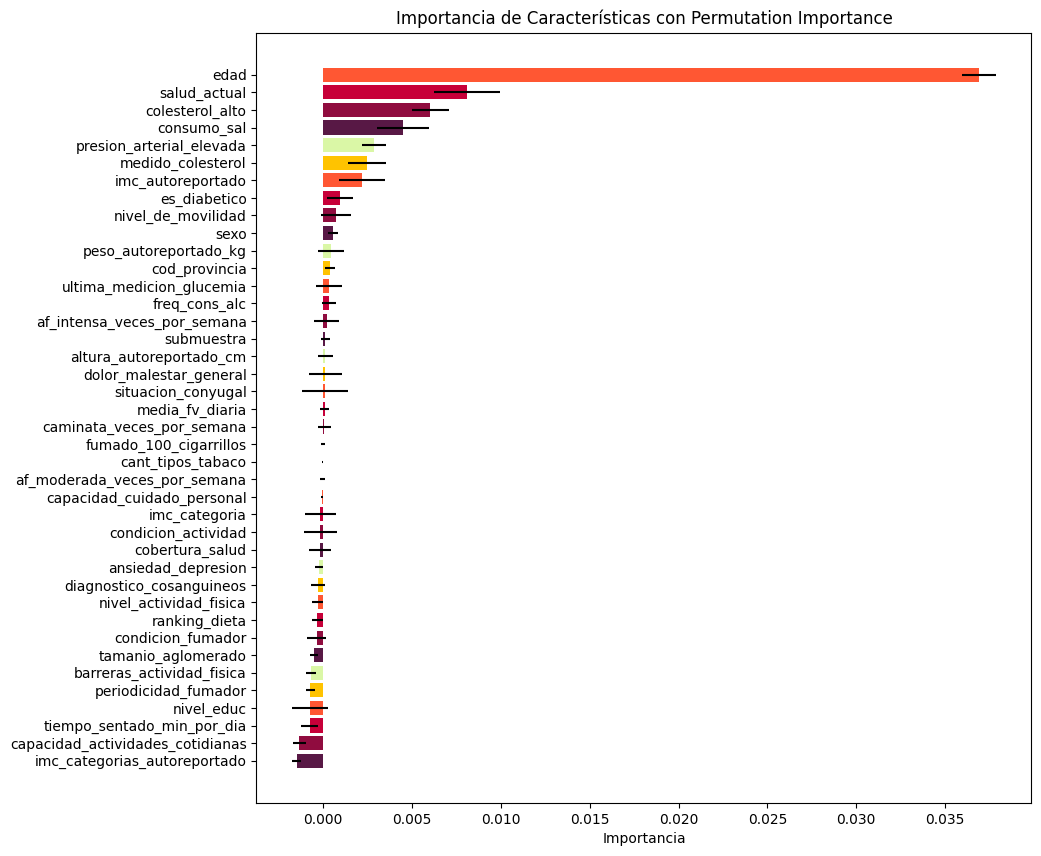

In [30]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 10))
plt.barh(features, importances, xerr=importances_std, align='center',color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.xlabel('Importancia')
plt.title('Importancia de Características con Permutation Importance')
plt.show()

Se seleccionarán las 10 características principales, que son aquellas que más contribuyen a la precisión del modelo. 

In [31]:
friesgo_reducida = friesgo_cod.filter(items=[
    'edad',
    'salud_actual',
    'colesterol_alto',
    'consumo_sal',
    'presion_arterial_elevada',
    'medido_colesterol',
    'imc_autoreportado_kg',
    'es_diabetico',
    'nivel_de_movilidad',
    'sexo',
])

Este nuevo DataFrame servirá de entrada para los siguientes algoritmos no supervisados.

### Metodo por Algoritmo No Supervisado

### Estandarizar datos

PCA es sensible a la escala de las columnas. La estandarización asegura que cada característica contribuya igualmente al análisis.

In [35]:
# Estandarización de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(friesgo_reducida)

### Evaluar el número óptimo de componentes para PCA

Para conservar el 95% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [37]:
pca = PCA(n_components = 0.95)
pca_data = pca.fit_transform(scaled_data)
n_components = pca.n_components_

# Ver el número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {n_components}")

Número de componentes seleccionados: 9


### Aplicar PCA 

Se aplica PCA con el número de componentes principales calculado con anterioridad.

In [38]:
# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components = n_components)
pca_opt_data = pca_opt.fit_transform(scaled_data)

# Convertir a DataFrame para facilitar el manejo
pca_df = pd.DataFrame(data = pca_opt_data, columns = [f'PC{i+1}' for i in range(n_components)])

### Visualizar la varianza explicada 

Permite ver cómo cada componente principal contribuye a la varianza total y cómo se acumula la varianza explicada.

In [39]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada')
for i in range(n_components):
    print('PC{}: {}'.format(i+1, pca.explained_variance_ratio_[i]))

Varianza explicada
PC1: 0.24243151962866544
PC2: 0.12710934083659922
PC3: 0.114603525440156
PC4: 0.10951112519919246
PC5: 0.10403648763065186
PC6: 0.09580703940340134
PC7: 0.07908846524682447
PC8: 0.06719172599053952
PC9: 0.060220770623969626


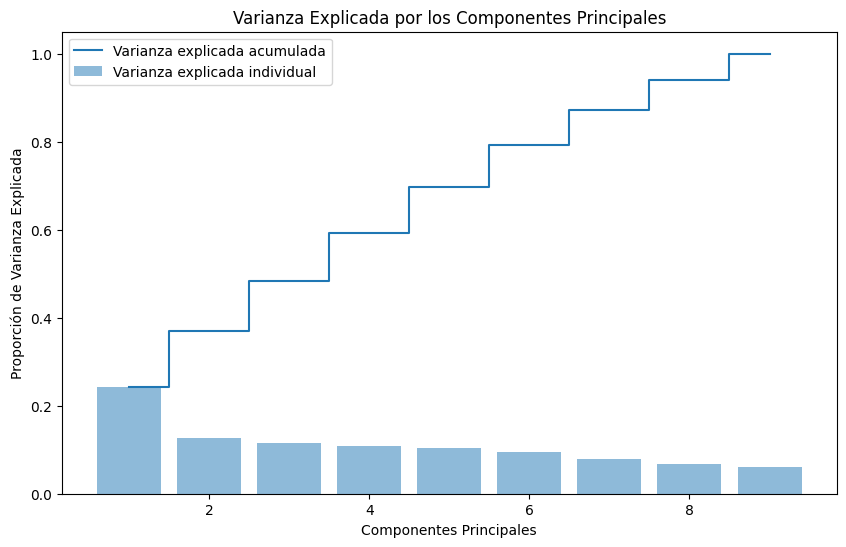

In [40]:
# Visualización de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(np.cumsum(explained_variance)) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.show()

## Análisis de modelos

### Modelo 1: K-Means

In [ ]:
# test codo

### Modelo 2: DBSCAN